<a href="https://colab.research.google.com/github/zahraniayudyaa/TUGAS-ML/blob/main/ch_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Pengenalan Klasifikasi**
---
Klasifikasi adalah salah satu tugas utama dalam pembelajaran mesin supervisi, di mana model belajar untuk memprediksi kelas atau kategori dari suatu data. Berbeda dengan regresi yang memprediksi nilai numerik, klasifikasi menghasilkan label diskrit.

# **2. Dataset MNIST**
---
MNIST adalah dataset yang terdiri dari 70.000 gambar angka tulisan tangan berukuran 28×28 piksel. Setiap gambar dilabeli dengan angka 0 hingga 9 yang diwakilinya. Dataset ini sering disebut sebagai "hello world" dalam pembelajaran mesin.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
print("Keys:", mnist.keys())

Keys: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


# **3. Eksplorasi Data**
---
Struktur dataset:
* **data:** array fitur (70000, 784)
* **target**: array label (70000,)

In [2]:
X, y = mnist["data"], mnist["target"]
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Convert y to integers
y = y.astype(np.uint8)

Shape of X: (70000, 784)
Shape of y: (70000,)


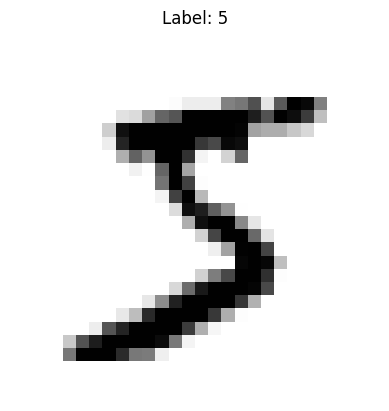

In [3]:
# Display first digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title(f"Label: {y[0]}")
plt.show()

# **4. Membagi Data Latih dan Uji**
---
Dataset sudah dibagi: 60.000 training, 10.000 testing.

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 60000
Test set size: 10000


# **5. Training a Binary Classifier**
---
Membuat classifier biner untuk mendeteksi angka 5.

In [5]:
# Create binary labels for digit 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print("Number of 5s in training set:", sum(y_train_5))
print("Number of non-5s in training set:", len(y_train_5) - sum(y_train_5))

Number of 5s in training set: 5421
Number of non-5s in training set: 54579


Menggunakan SGDClassifier:

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Test prediction on first digit
print("Prediction for first digit (should be True for 5):", sgd_clf.predict([some_digit]))

Prediction for first digit (should be True for 5): [ True]


# **6. Performance Measures: Cross-Validation**
---
Menggunakan cross-validation untuk evaluasi:

In [7]:
from sklearn.model_selection import cross_val_score

# 3-fold cross-validation
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.95035 0.96035 0.9604 ]
Mean accuracy: 0.9570333333333334


Contoh classifier "bodoh" yang selalu memprediksi "bukan 5":

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
dumb_scores = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Never5Classifier accuracy scores:", dumb_scores)
print("This shows accuracy can be misleading for imbalanced datasets!")

Never5Classifier accuracy scores: [0.91125 0.90855 0.90915]
This shows accuracy can be misleading for imbalanced datasets!


# **7. Confusion Matrix**
---
Cara yang lebih baik untuk evaluasi:

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Get predictions using cross-validation
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Compute confusion matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print("Confusion Matrix:")
print(cm)

# Interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

Confusion Matrix:
[[53892   687]
 [ 1891  3530]]

True Negatives: 53892
False Positives: 687
False Negatives: 1891
True Positives: 3530


# **8. Precision dan Recall**
---

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8371
Recall: 0.6512
F1 Score: 0.7325


# **9. Precision/Recall Trade-off**
---
Mengakses decision function:

In [11]:
# Get decision scores
y_scores = sgd_clf.decision_function([some_digit])
print(f"Decision score for first digit: {y_scores[0]:.2f}")

# Experiment with different thresholds
thresholds = [0, 2000, 4000, 8000]
for threshold in thresholds:
    y_pred_threshold = (y_scores > threshold)
    print(f"Threshold {threshold}: Prediction = {y_pred_threshold[0]}")

Decision score for first digit: 2164.22
Threshold 0: Prediction = True
Threshold 2000: Prediction = True
Threshold 4000: Prediction = False
Threshold 8000: Prediction = False


Mendapatkan semua skor dengan cross-validation:

In [12]:
# Get decision scores for all training instances
y_scores_all = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                 method="decision_function")
print(f"Shape of y_scores_all: {y_scores_all.shape}")

Shape of y_scores_all: (60000,)


# **10. Plot Precision-Recall Curve**
---

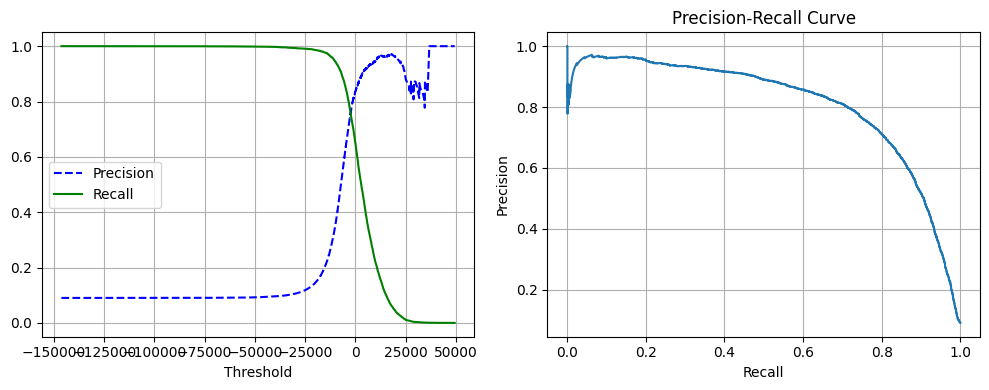

In [13]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_all)

# Plot precision-recall curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)

plt.tight_layout()
plt.show()

# **11. ROC Curve**
---

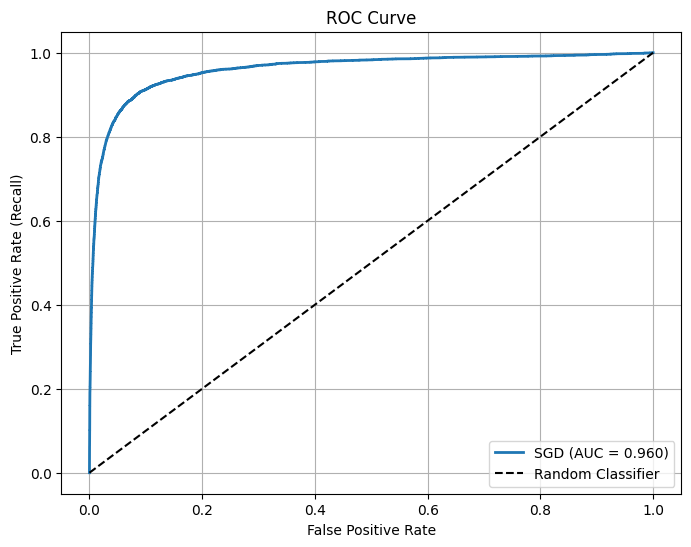

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores_all)
roc_auc = roc_auc_score(y_train_5, y_scores_all)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"SGD (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **12. Random Forest Classifier**
---

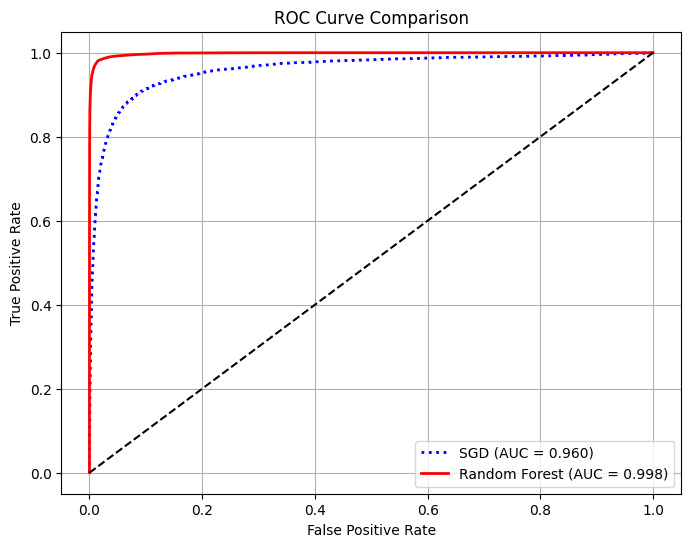

Random Forest ROC AUC: 0.9983


In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
forest_clf = RandomForestClassifier(random_state=42, n_estimators=100)
# Get probability predictions using cross-validation
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

# Use positive class probability as score
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
roc_auc_forest = roc_auc_score(y_train_5, y_scores_forest)

# Compare ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label=f"SGD (AUC = {roc_auc:.3f})")
plt.plot(fpr_forest, tpr_forest, "r-", linewidth=2, label=f"Random Forest (AUC = {roc_auc_forest:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Random Forest ROC AUC: {roc_auc_forest:.4f}")

# **13. Multiclass Classification**
---
Menggunakan SVC dengan strategi OvO otomatis:

In [16]:
from sklearn.svm import SVC

# Note: SVC training can be slow on full dataset
# Let's use a subset for demonstration
sample_size = 10000
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]

svm_clf = SVC()
svm_clf.fit(X_train_sample, y_train_sample)

# Test prediction
svm_pred = svm_clf.predict([some_digit])
print(f"SVC prediction for first digit: {svm_pred[0]}")

# Decision scores
some_digit_scores = svm_clf.decision_function([some_digit])
print(f"\nDecision scores for all classes:\n{some_digit_scores}")
print(f"Class with highest score: {np.argmax(some_digit_scores)}")
print(f"Available classes: {svm_clf.classes_}")

SVC prediction for first digit: 5

Decision scores for all classes:
[[ 0.73640179  3.74695649  6.22503198  8.30364879 -0.30459674  9.30612304
   1.73376956  3.76312093  7.22128341  3.7959883 ]]
Class with highest score: 5
Available classes: [0 1 2 3 4 5 6 7 8 9]


# **14. Menggunakan SGDClassifier untuk Multiclass**
---

In [17]:
# Train SGDClassifier for multiclass
sgd_clf_multiclass = SGDClassifier(random_state=42)
sgd_clf_multiclass.fit(X_train, y_train)

# Test prediction
sgd_pred = sgd_clf_multiclass.predict([some_digit])
print(f"SGD prediction for first digit: {sgd_pred[0]}")

# Decision scores
sgd_scores = sgd_clf_multiclass.decision_function([some_digit])
print(f"\nSGD decision scores:\n{sgd_scores}")
print(f"Class with highest score: {np.argmax(sgd_scores)}")

SGD prediction for first digit: 3

SGD decision scores:
[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
Class with highest score: 3


Evaluasi dengan cross-validation:

In [18]:
# Evaluate with cross-validation (using subset for speed)
from sklearn.model_selection import cross_val_score

sgd_scores_cv = cross_val_score(sgd_clf_multiclass, X_train[:5000], y_train[:5000],
                                cv=3, scoring="accuracy")
print(f"SGDClassifier cross-validation scores: {sgd_scores_cv}")
print(f"Mean accuracy: {sgd_scores_cv.mean():.4f}")

SGDClassifier cross-validation scores: [0.83863227 0.86262747 0.84993998]
Mean accuracy: 0.8504


Feature Scaling:

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Train and evaluate with scaling
sgd_clf_scaled = SGDClassifier(random_state=42)
sgd_scores_scaled = cross_val_score(sgd_clf_scaled, X_train_scaled[:5000],
                                    y_train[:5000], cv=3, scoring="accuracy")
print(f"SGDClassifier with scaling scores: {sgd_scores_scaled}")
print(f"Mean accuracy with scaling: {sgd_scores_scaled.mean():.4f}")

SGDClassifier with scaling scores: [0.85722855 0.89082184 0.89555822]
Mean accuracy with scaling: 0.8812


# **15. Error Analysis**
---
Confusion matrix untuk multiclass:

Confusion matrix (first 10 rows/cols):
[[460   0   3   2   2   7   3   0   2   0]
 [  0 535   5   2   1   5   0   1  13   1]
 [  4  11 410  14  14   4  10   6  15   0]
 [  2   4  18 405   0  34   1  12  12   5]
 [  3   1   7   2 483   0   6   2  11  20]
 [  6   5   3  18   9 352   9   1  20  11]
 [  4   4   9   0   6  10 463   0   5   0]
 [  3   3   3   4   9   0   0 495   1  32]
 [  1  16  13  16   2   8   9   5 384   8]
 [  6   4   5   6  19   5   0  25   6 419]]


<Figure size 1000x800 with 0 Axes>

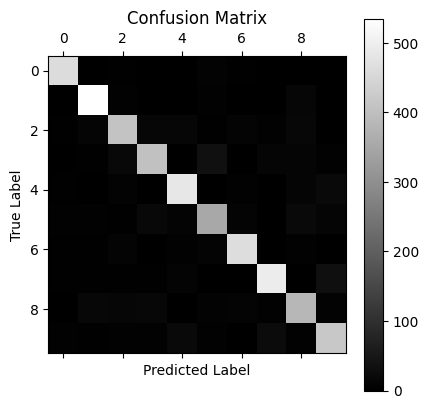

In [20]:
# Get predictions for error analysis
y_train_pred = cross_val_predict(sgd_clf_scaled, X_train_scaled[:5000],
                                 y_train[:5000], cv=3)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train[:5000], y_train_pred)
print("Confusion matrix (first 10 rows/cols):")
print(conf_mx[:10, :10])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Normalisasi dan fokus pada error:

<Figure size 1000x800 with 0 Axes>

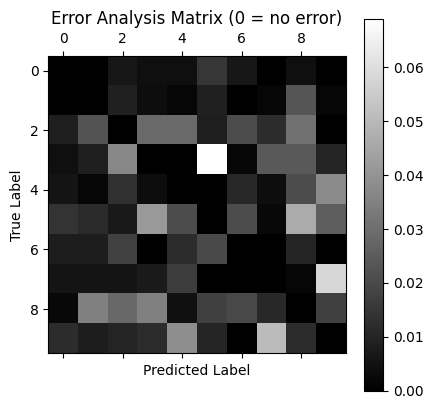

In [21]:
# Normalize confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Fill diagonal with zeros to highlight errors
np.fill_diagonal(norm_conf_mx, 0)

# Plot error matrix
plt.figure(figsize=(10, 8))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Error Analysis Matrix (0 = no error)")
plt.colorbar()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# **16. Multilabel Classification**
---

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Create multilabel targets
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

print("First 5 multilabel targets:")
print(y_multilabel[:5])
print("Labels: [is_large(7,8,9), is_odd]")

# Train KNN classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train[:2000], y_multilabel[:2000])  # Use subset for speed

# Test prediction
knn_pred = knn_clf.predict([some_digit])
print(f"\nKNN prediction for digit 5: {knn_pred[0]}")
print("Interpretation: [is_large=False, is_odd=True] ✓")

# Evaluate with F1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train[:1000], y_multilabel[:1000], cv=3)
f1_macro = f1_score(y_multilabel[:1000], y_train_knn_pred, average="macro")
f1_weighted = f1_score(y_multilabel[:1000], y_train_knn_pred, average="weighted")

print(f"\nF1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")

First 5 multilabel targets:
[[False  True]
 [False False]
 [False False]
 [False  True]
 [ True  True]]
Labels: [is_large(7,8,9), is_odd]

KNN prediction for digit 5: [False  True]
Interpretation: [is_large=False, is_odd=True] ✓

F1 Score (macro): 0.8885
F1 Score (weighted): 0.8923


# **17. Multioutput Classification**
---
Contoh: denoising gambar.

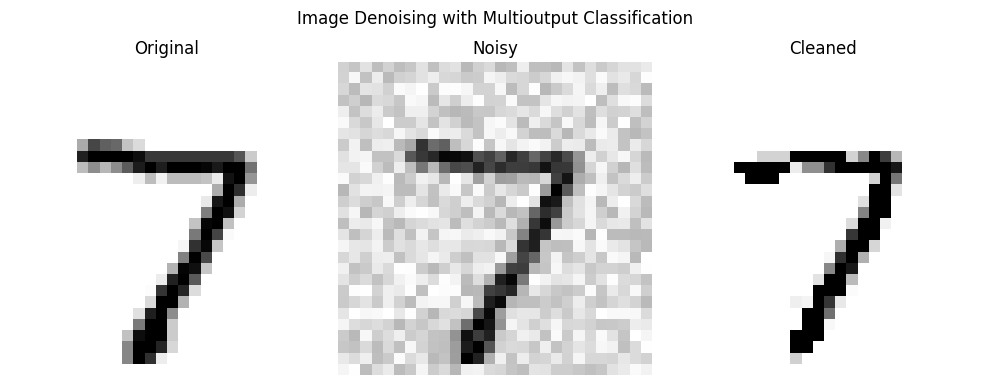

In [23]:
# Add noise to images
noise_train = np.random.randint(0, 100, (len(X_train[:1000]), 784))
noise_test = np.random.randint(0, 100, (len(X_test[:100]), 784))

X_train_mod = X_train[:1000] + noise_train
X_test_mod = X_test[:100] + noise_test
y_train_mod = X_train[:1000]
y_test_mod = X_test[:100]

# Train KNN for denoising
knn_clf_denoise = KNeighborsClassifier()
knn_clf_denoise.fit(X_train_mod, y_train_mod)

# Clean a noisy image
clean_digit = knn_clf_denoise.predict([X_test_mod[0]])

# Visualize original, noisy, and cleaned
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Original
axes[0].imshow(y_test_mod[0].reshape(28, 28), cmap="binary")
axes[0].set_title("Original")
axes[0].axis("off")

# Noisy
axes[1].imshow(X_test_mod[0].reshape(28, 28), cmap="binary")
axes[1].set_title("Noisy")
axes[1].axis("off")

# Cleaned
axes[2].imshow(clean_digit[0].reshape(28, 28), cmap="binary")
axes[2].set_title("Cleaned")
axes[2].axis("off")

plt.suptitle("Image Denoising with Multioutput Classification")
plt.tight_layout()
plt.show()